
# Plant project

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl

import tensorflow as tf
import os
import cv2
import imghdr
import json
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Input
from keras.callbacks import EarlyStopping
from keras.losses import sparse_categorical_crossentropy, categorical_crossentropy
from keras.optimizers import Adam, SGD
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

from sklearn.svm import LinearSVC
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

C:\Users\Amand\AppData\Local\Temp\ipykernel_118256\354183251.py:9: DeprecationWarning: 'imghdr' is deprecated and slated for removal in Python 3.13
  import imghdr


## Functions

In [2]:
def display_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)
    ConfusionMatrixDisplay(cm).plot()

In [3]:
#Multi-task model functions
# Define a simple color extraction function (based on average pixel color)
def extract_dominant_color(images):
    # Extracts the mean of RGB values as color "label"
    return np.mean(images, axis=(1, 2))

# Convert color labels to a simplified categorical (e.g., for 3 colors: red, green, blue)
def categorize_colors(colors):
    color_categories = np.zeros((colors.shape[0], 3))  # For Red, Green, Blue categories
    color_categories[np.argmax(colors, axis=1) == 0, 0] = 1  # Red
    color_categories[np.argmax(colors, axis=1) == 1, 1] = 1  # Green
    color_categories[np.argmax(colors, axis=1) == 2, 2] = 1  # Blue
    return color_categories

# Build the CNN model with two outputs
def build_multi_output_model(input_shape):
    model = Sequential()
    inputs = Input(shape=input_shape)
    
    # Add convolutional layers
    x = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
    x = MaxPooling2D()(x)
    x = Conv2D(64, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D()(x)
    x = Conv2D(128, kernel_size=(3, 3), activation='relu')(x)
    x = MaxPooling2D()(x)

    # Flatten before feeding to dense layers
    x = Flatten()(x)

    # Shared dense layer
    x = Dense(128, activation='relu')(x)

    # Output 1: Object classification
    output_classification = Dense(10, activation='softmax', name='classification_output')(x)

    # Output 2: Color identification
    output_color = Dense(3, activation='softmax', name='color_output')(x)

    # Create a model with two outputs
    model = Model(inputs=inputs, outputs=[output_classification, output_color])
    return model

In [4]:
def VGG16(nr_of_classes, height, width,):

    model = Sequential()
    
    model.add(Input(shape=(height, width, 3)))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))

    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'))

    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))

    model.add(Conv2D(filters=128, kernel_size=(3, 3),  padding='same', activation='relu'))

    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'))

    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))

    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))

    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))

    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))

    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))

    model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'))

    model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'))

    model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'))

    model.add(MaxPooling2D(pool_size=(2, 2),strides=(2, 2)))

    model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'))

    model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'))

    model.add(Conv2D(filters=512, kernel_size=(3, 3), padding='same', activation='relu'))

    model.add(MaxPooling2D(pool_size=(2, 2), strides=(2,2), name='vgg16'))

    model.add(Flatten(name='flatten'))

    model.add(Dense(256, activation='relu', name='fc1'))

    model.add(Dense(128, activation='relu', name='fc2'))

    model.add(Dense(nr_of_classes, activation='softmax', name='output'))

    return model

## Recurring variables

In [5]:
height = 256
width = 256
size_of_batch = 32
nr_of_classes = 30

## Load the dataset

In [2]:

# Data localy stored
data_path_train = r'data\split_ttv_dataset_type_of_plants\Train_Set_Folder'
data_path_val = r'data\split_ttv_dataset_type_of_plants\Validation_Set_Folder'
data_path_test = r'data\split_ttv_dataset_type_of_plants\Test_Set_Folder'


data_train = tf.keras.utils.image_dataset_from_directory(data_path_train) 
data_val = tf.keras.utils.image_dataset_from_directory(data_path_val)
data_test = tf.keras.utils.image_dataset_from_directory(data_path_test)

train_labels = np.concatenate([y for x, y in data_train], axis=0)
val_labels = np.concatenate([y for x, y in data_val], axis=0)
test_labels = np.concatenate([y for x, y in data_test], axis=0)

data_train_iterator = data_train.as_numpy_iterator()
data_val_iterator = data_val.as_numpy_iterator()
data_test_iterator = data_test.as_numpy_iterator()

Found 23972 files belonging to 30 classes.
Found 3030 files belonging to 30 classes.
Found 2998 files belonging to 30 classes.


In [13]:
train_labels

array([17, 27, 15, ...,  8, 12,  1])

In [25]:
# Lables from json file
path_to_json = r'data\plantnet_300K\plantnet300K_species_id_2_name.json'

plantnet300K_names = json.load(open(path_to_json, encoding='utf-8'))

print(plantnet300K_names)
print(plantnet300K_names['1355920'])

{'1355868': 'Lactuca virosa L.', '1355920': "Pelargonium capitatum (L.) L'Hér.", '1355932': "Pelargonium graveolens L'Hér.", '1355936': 'Cirsium arvense (L.) Scop.', '1355937': 'Cirsium vulgare (Savi) Ten.', '1355955': "Pelargonium odoratissimum (L.) L'Hér.", '1355959': "Pelargonium peltatum (L.) L'Hér.", '1355961': "Pelargonium quercifolium (L. f.) L'Hér.", '1355978': "Pelargonium zonale (L.) L'Hér.", '1355990': 'Mercurialis annua L.', '1356003': 'Phyllanthus tenellus Roxb.', '1356022': 'Hypericum perforatum L.', '1356037': 'Egeria densa Planch.', '1356055': 'Ibicella lutea (Lindl.) Van Eselt.', '1356075': 'Tradescantia fluminensis Vell.', '1356076': 'Tradescantia zebrina Heynh. ex Bosse', '1356111': 'Lamium amplexicaule L.', '1356126': 'Lavandula dentata L.', '1356138': 'Striga asiatica (L.) Kuntze', '1356257': 'Melilotus albus Medik.', '1356278': 'Trifolium fragiferum L.', '1356279': 'Asystasia gangetica (L.) T. Anderson', '1356309': 'Nymphaea nouchali Burm. f.', '1356379': 'Dryopte

In [7]:
# Load CIFAR-10 dataset 
(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()

# Normalize the images
train_images = train_images.astype('float32') / 255.0
test_images = test_images.astype('float32') / 255.0

# Convert labels to categorical (for classification task)
train_labels_class = to_categorical(train_labels, 10)
test_labels_class = to_categorical(test_labels, 10)

# Get color labels (as a separate task for color classification)
train_colors = extract_dominant_color(train_images)
test_colors = extract_dominant_color(test_images)

train_colors_cat = categorize_colors(train_colors)
test_colors_cat = categorize_colors(test_colors)

In [5]:
batch_train = data_train_iterator.next()
batch_val = data_val_iterator.next()
batch_test = data_test_iterator.next()

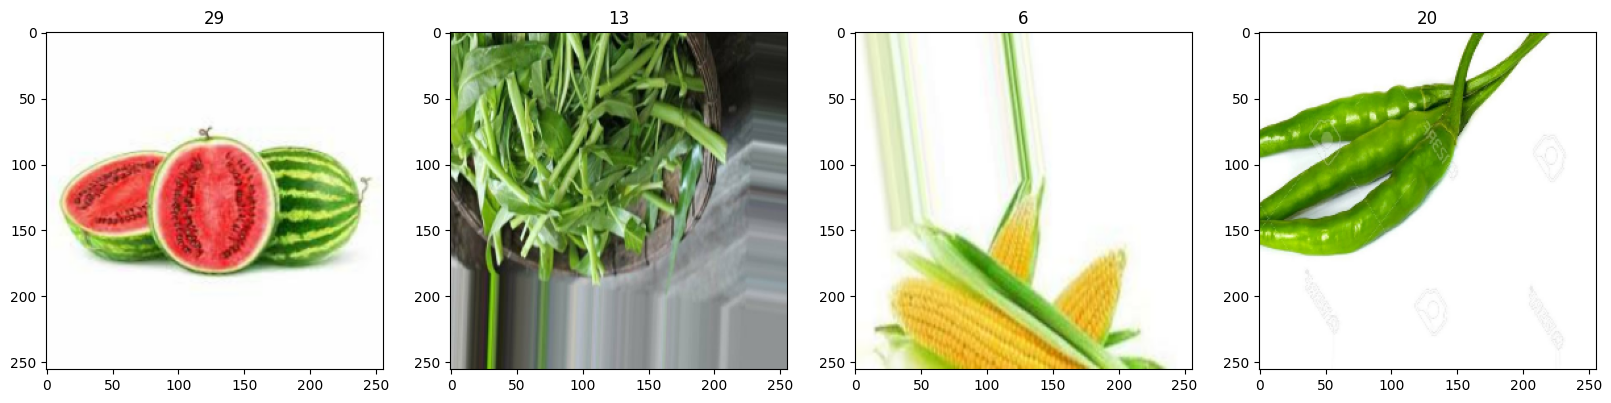

In [6]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, img in enumerate(batch_train[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch_train[1][idx])

## Scale the data

In [7]:
train = data_train.map(lambda x,y: (x/255, y))
val = data_val.map(lambda x,y: (x/255, y))
test = data_test.map(lambda x,y: (x/255, y))

In [8]:
train.as_numpy_iterator().next()
val.as_numpy_iterator().next()
test.as_numpy_iterator().next()

(array([[[[0.51390934, 0.36885723, 0.53741574],
          [0.4814199 , 0.36630177, 0.52491647],
          [0.43193027, 0.36635467, 0.513098  ],
          ...,
          [0.64544165, 0.55911875, 0.37031046],
          [0.71329105, 0.5035156 , 0.3165072 ],
          [0.77559745, 0.5010187 , 0.30904564]],
 
         [[0.54571843, 0.409015  , 0.5655331 ],
          [0.50835216, 0.39631087, 0.550332  ],
          [0.45454198, 0.3841762 , 0.5291456 ],
          ...,
          [0.5591135 , 0.39962646, 0.23679633],
          [0.5828163 , 0.34016398, 0.18050765],
          [0.62469363, 0.3377987 , 0.17818627]],
 
         [[0.5818857 , 0.47634804, 0.61325824],
          [0.5492793 , 0.45123237, 0.5856457 ],
          [0.4982754 , 0.41801912, 0.54959655],
          ...,
          [0.46694756, 0.1600956 , 0.05609744],
          [0.46146753, 0.14291857, 0.04653377],
          [0.47116268, 0.1479856 , 0.05409773]],
 
         ...,
 
         [[0.498269  , 0.42745098, 0.5219133 ],
          [0.49826

## Build the model

In [ ]:
model = Sequential()

model.add(Input(shape=(height, width, 3)))

model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D())
model.add(Conv2D(16, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(256, activation='relu'))

model.add(Dense(nr_of_classes, activation='softmax'))

model.compile(optimizer=Adam(), loss=sparse_categorical_crossentropy, metrics=['accuracy'])

In [ ]:
model.summary()

In [ ]:
logdir='logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tensorboard_callback])

In [ ]:
# Define multi model
input_shape = train_images.shape[1:]
multi_model = build_multi_output_model(input_shape)

# Compile the model
multi_model.compile(optimizer='adam',
              loss={'classification_output': 'categorical_crossentropy', 'color_output': 'categorical_crossentropy'},
              metrics={'classification_output': 'accuracy', 'color_output': 'accuracy'})

multi_model.summary()

In [ ]:
# Train the multi model
history = multi_model.fit(train_images, 
                    {'classification_output': train_labels_class, 'color_output': train_colors_cat},
                    epochs=10, 
                    batch_size=64, 
                    validation_data=(test_images, 
                                     {'classification_output': test_labels_class, 'color_output': test_colors_cat}))

In [ ]:
# VGG16
model_vgg16 = VGG16(nr_of_classes, height, width)

opt = SGD(learning_rate=0.001, momentum=0.9)

model_vgg16.compile(loss=sparse_categorical_crossentropy, optimizer='adam', metrics=['accuracy'])

model_vgg16.summary()

In [ ]:
es = EarlyStopping(monitor='val_accuracy', verbose=1, patience=3)

h = model_vgg16.fit(train, validation_data=val, epochs=20, verbose=1, callbacks=[es])

In [ ]:
model_name = "model-v2.h5"
model.save(model_name)

score = model.evaluate(test)
print('Test Loss:', score[0])
print('Test accuracy:', score[1])

In [ ]:
multi_model_name = "multi_model-v1.h5"
multi_model.save(multi_model_name)
# Evaluate the model
loss, class_loss, color_loss, class_acc, color_acc = multi_model.evaluate(test_images, 
                                                                    {'classification_output': test_labels_class, 
                                                                     'color_output': test_colors_cat})

print(f"Classification Accuracy: {class_acc}")
print(f"Color Identification Accuracy: {color_acc}")

In [ ]:
# Visualize training history
plt.plot(history.history['classification_output_accuracy'], label='Classification Accuracy')
plt.plot(history.history['color_output_accuracy'], label='Color Identification Accuracy')
plt.legend()
plt.show()

# Predict on a sample image
sample_image = test_images[0:1]  # Choose a sample image
predictions = multi_model.predict(sample_image)

print("Predicted Class:", np.argmax(predictions[0]))
print("Predicted Color:", np.argmax(predictions[1]))